# **Training**

---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
# import the necessary packages
!pip install -q keras
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# Parameters and Loading Pictures

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
# imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

incorrect_mask_path = '/content/drive/MyDrive/Colab Notebooks/dataset/incorrect_mask'
with_mask_path = '/content/drive/MyDrive/Colab Notebooks/dataset/with_mask'
without_mask_path = '/content/drive/MyDrive/Colab Notebooks/dataset/without_mask'

for f in os.listdir(incorrect_mask_path):
  image = load_img(os.path.join(incorrect_mask_path, f), target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(0)

for f in os.listdir(with_mask_path):
  image = load_img(os.path.join(with_mask_path, f), target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(1)

for f in os.listdir(without_mask_path):
  image = load_img(os.path.join(without_mask_path, f), target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(2)

[INFO] loading images...


# One-Hot Encoding

In [5]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = labels.astype(dtype = np.uint8)

# Training and Predict

In [6]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(trainX, trainY, steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
51/51 [==============================] - 39s 87ms/step - loss: 1.1688 - accuracy: 0.4776 - val_loss: 0.3039 - val_accuracy: 0.9423
Epoch 2/20
51/51 [==============================] - 3s 56ms/step - loss: 0.3728 - accuracy: 0.8725 - val_loss: 0.1732 - val_accuracy: 0.9639
Epoch 3/20
51/51 [==============================] - 3s 55ms/step - loss: 0.2103 - accuracy: 0.9318 - val_loss: 0.1359 - val_accuracy: 0.9663
Epoch 4/20
51/51 [==============================] - 3s 55ms/step - loss: 0.1574 - accuracy: 0.9534 - val_loss: 0.1100 - val_accuracy: 0.9760
Epoch 5/20
51/51 [==============================] - 3s 55ms/step - loss: 0.1133 - accuracy: 0.9684 - val_loss: 0.0955 - val_accuracy: 0.9760
Epoch 6/20
51/51 [==============================] - 3s 55ms/step - loss: 0.0848 - accuracy: 0.9775 - val_loss: 0.0877 - val_accuracy: 0.9712
Epoch 7/20
51/51 [======================

# Plotting and Saving

[INFO] saving mask detector model...


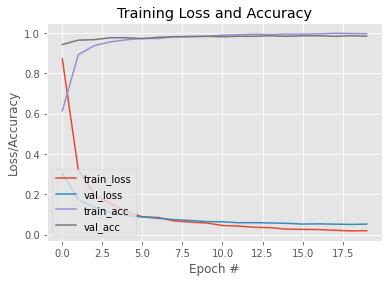

In [7]:
# show a nicely formatted classification report
#print(lb.classes_)
#print(classification_report(testY.argmax(axis=1), predIdxs,
#	target_names=[0, 1, 2]))
# serialize the model to disk

print("[INFO] saving mask detector model...")
mydir = '/content/drive/MyDrive/Colab Notebooks/models'

try:
   if not os.path.exists(os.path.dirname(mydir)):
       os.makedirs(os.path.dirname(mydir))
except OSError as err:
   print(err)

model.save('/content/drive/MyDrive/Colab Notebooks/models/mask_detector.h5')   # Saving model

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
# plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

mydir = '/content/drive/MyDrive/Colab Notebooks/Plots'

try:
  if not os.path.exists(os.path.dirname(mydir)):
        os.makedirs(os.path.dirname(mydir))
except OSError as err:
    print(err)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/plot.png')